## Porto Seguro’s Safe Driver Prediction

The aim is to predict probability that a driver will intiate an auto insurance claim next year.A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV

%matplotlib inline
seed = 42

In [2]:
train = pd.read_csv('../data/porto_train.csv', na_values=-1)
test = pd.read_csv('../data/porto_test.csv', na_values=-1)

In [3]:
train.shape

(595212, 59)

In [4]:
test.shape

(892816, 58)

In [5]:
train.head(3).T

0          1          2
id               7.000000   9.000000  13.000000
target           0.000000   0.000000   0.000000
ps_ind_01        2.000000   1.000000   5.000000
ps_ind_02_cat    2.000000   1.000000   4.000000
ps_ind_03        5.000000   7.000000   9.000000
ps_ind_04_cat    1.000000   0.000000   1.000000
ps_ind_05_cat    0.000000   0.000000   0.000000
ps_ind_06_bin    0.000000   0.000000   0.000000
ps_ind_07_bin    1.000000   0.000000   0.000000
ps_ind_08_bin    0.000000   1.000000   1.000000
ps_ind_09_bin    0.000000   0.000000   0.000000
ps_ind_10_bin    0.000000   0.000000   0.000000
ps_ind_11_bin    0.000000   0.000000   0.000000
ps_ind_12_bin    0.000000   0.000000   0.000000
ps_ind_13_bin    0.000000   0.000000   0.000000
ps_ind_14        0.000000   0.000000   0.000000
ps_ind_15       11.000000   3.000000  12.000000
ps_ind_16_bin    0.000000   0.000000   1.000000
ps_ind_17_bin    1.000000   0.000000   0.000000
ps_ind_18_bin    0.000000   1.000000   0.000000
ps_reg_01        0.700000   0.800000   0.000000
ps_reg_02        0.200000   0.400000   0.000000
ps_reg_03        0.718070   0.766078        NaN
ps_car_01_cat   10.000000  11.000000   7.000000
ps_car_02_cat    1.000000   1.000000   1.000000
ps_car_03_cat         NaN        NaN        NaN
ps_car_04_cat    0.000000   0.000000   0.000000
ps_car_05_cat    1.000000        NaN        NaN
ps_car_06_cat    4.000000  11.000000  14.000000
ps_car_07_cat    1.000000   1.000000   1.000000
ps_car_08_cat    0.000000   1.000000   1.000000
ps_car_09_cat    0.000000   2.000000   2.000000
ps_car_10_cat    1.000000   1.000000   1.000000
ps_car_11_cat   12.000000  19.000000  60.000000
ps_car_11        2.000000   3.000000   1.000000
ps_car_12        0.400000   0.316228   0.316228
ps_car_13        0.883679   0.618817   0.641586
ps_car_14        0.370810   0.388716   0.347275
ps_car_15        3.605551   2.449490   3.316625
ps_calc_01       0.600000   0.300000   0.500000
ps_calc_02       0.500000   0.100000   0.700000
ps_calc_03       0.200000   0.300000   0.100000
ps_calc_04       3.000000   2.000000   2.000000
ps_calc_05       1.000000   1.000000   2.000000
ps_calc_06      10.000000   9.000000   9.000000
ps_calc_07       1.000000   5.000000   1.000000
ps_calc_08      10.000000   8.000000   8.000000
ps_calc_09       1.000000   1.000000   2.000000
ps_calc_10       5.000000   7.000000   7.000000
ps_calc_11       9.000000   3.000000   4.000000
ps_calc_12       1.000000   1.000000   2.000000
ps_calc_13       5.000000   1.000000   7.000000
ps_calc_14       8.000000   9.000000   7.000000
ps_calc_15_bin   0.000000   0.000000   0.000000
ps_calc_16_bin   1.000000   1.000000   1.000000
ps_calc_17_bin   1.000000   1.000000   1.000000
ps_calc_18_bin   0.000000   0.000000   0.000000
ps_calc_19_bin   0.000000   1.000000   1.000000
ps_calc_20_bin   1.000000   0.000000   0.000000

0    573518
1     21694
Name: target, dtype: int64

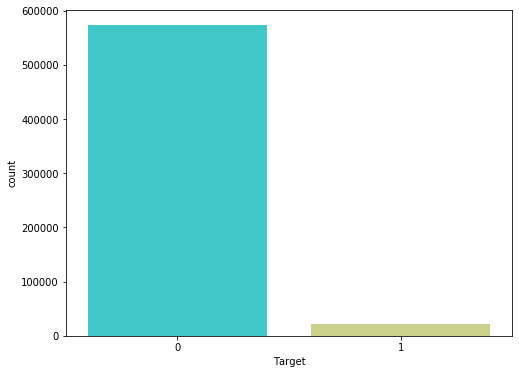

In [6]:
plt.figure(figsize=(8,6))
sns.countplot(train['target'], palette='rainbow')
plt.xlabel('Target')

train['target'].value_counts()

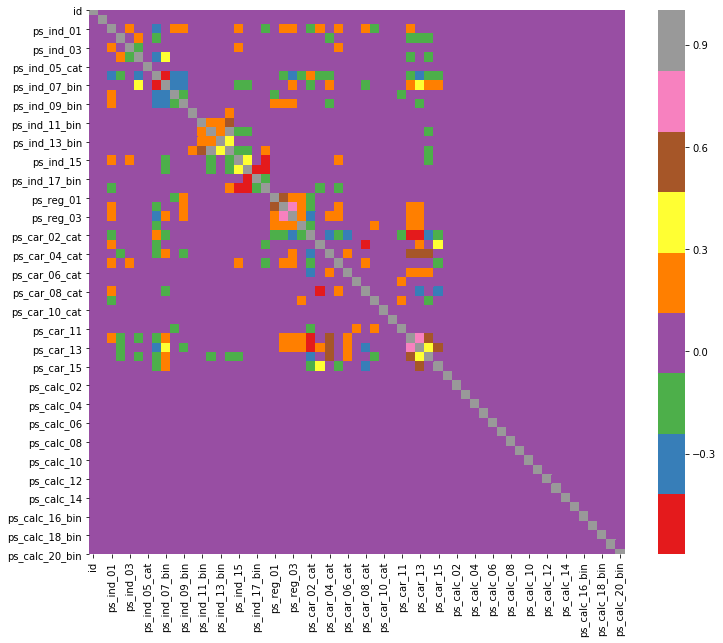

In [7]:
# correlation plot
corr = train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='Set1')

In [8]:
ps_cal = train.columns[train.columns.str.startswith('ps_calc')]
train = train.drop(ps_cal, axis=1)
test = test.drop(ps_cal, axis=1)
train.shape

(595212, 39)

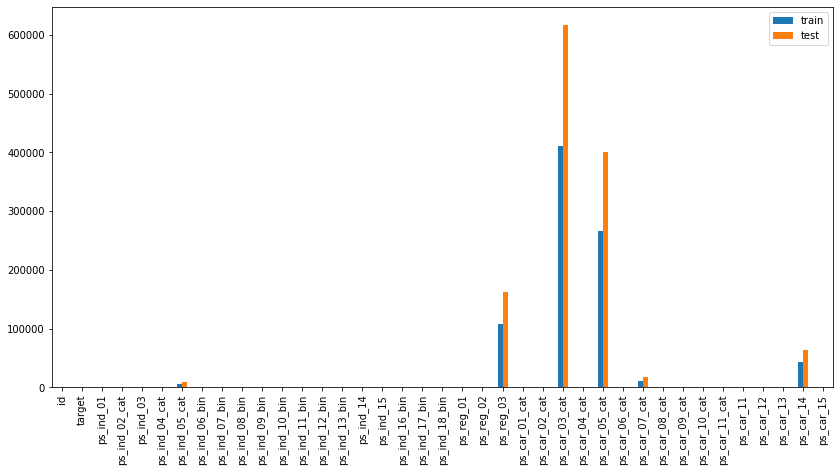

In [9]:
# missing values
k = pd.DataFrame()
k['train'] = train.isnull().sum()
k['test'] = test.isnull().sum()
fig,ax = plt.subplots(figsize=(14,7))
k.plot(kind='bar', ax=ax)

In [10]:
# replace missing values with mode
def missing_values(df):
    col = df.columns
    for i in col:
        if df[i].isnull().sum()>0:
            df[i].fillna(df[i].mode()[0], inplace=True)

In [11]:
missing_values(train)
missing_values(test)

In [12]:
# convert variables into category type
def basic_detail(df):
    b = pd.DataFrame()
    b['Missing values'] = df.isnull().sum()
    b['N unique values'] = b.nunique()
    b['dtype'] = b.dtypes
    
    return b

In [13]:
basic_detail(train)

Missing values  N unique values dtype
id                          0              NaN   NaN
target                      0              NaN   NaN
ps_ind_01                   0              NaN   NaN
ps_ind_02_cat               0              NaN   NaN
ps_ind_03                   0              NaN   NaN
ps_ind_04_cat               0              NaN   NaN
ps_ind_05_cat               0              NaN   NaN
ps_ind_06_bin               0              NaN   NaN
ps_ind_07_bin               0              NaN   NaN
ps_ind_08_bin               0              NaN   NaN
ps_ind_09_bin               0              NaN   NaN
ps_ind_10_bin               0              NaN   NaN
ps_ind_11_bin               0              NaN   NaN
ps_ind_12_bin               0              NaN   NaN
ps_ind_13_bin               0              NaN   NaN
ps_ind_14                   0              NaN   NaN
ps_ind_15                   0              NaN   NaN
ps_ind_16_bin               0              NaN   NaN
ps_ind_17_bin               0              NaN   NaN
ps_ind_18_bin               0              NaN   NaN
ps_reg_01                   0              NaN   NaN
ps_reg_02                   0              NaN   NaN
ps_reg_03                   0              NaN   NaN
ps_car_01_cat               0              NaN   NaN
ps_car_02_cat               0              NaN   NaN
ps_car_03_cat               0              NaN   NaN
ps_car_04_cat               0              NaN   NaN
ps_car_05_cat               0              NaN   NaN
ps_car_06_cat               0              NaN   NaN
ps_car_07_cat               0              NaN   NaN
ps_car_08_cat               0              NaN   NaN
ps_car_09_cat               0              NaN   NaN
ps_car_10_cat               0              NaN   NaN
ps_car_11_cat               0              NaN   NaN
ps_car_11                   0              NaN   NaN
ps_car_12                   0              NaN   NaN
ps_car_13                   0              NaN   NaN
ps_car_14                   0              NaN   NaN
ps_car_15                   0              NaN   NaN

In [14]:
train.head()

id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2            2.0          5            1.0   
1   9       0          1            1.0          7            0.0   
2  13       0          5            4.0          9            1.0   
3  16       0          0            1.0          2            0.0   
4  17       0          0            2.0          0            1.0   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ...  \
0            0.0              0              1              0  ...   
1            0.0              0              0              1  ...   
2            0.0              0              0              1  ...   
3            0.0              1              0              0  ...   
4            0.0              1              0              0  ...   

   ps_car_07_cat  ps_car_08_cat  ps_car_09_cat  ps_car_10_cat  ps_car_11_cat  \
0            1.0              0            0.0              1             12   
1            1.0              1            2.0              1             19   
2            1.0              1            2.0              1             60   
3            1.0              1            3.0              1            104   
4            1.0              1            2.0              1             82   

   ps_car_11  ps_car_12  ps_car_13  ps_car_14  ps_car_15  
0        2.0   0.400000   0.883679   0.370810   3.605551  
1        3.0   0.316228   0.618817   0.388716   2.449490  
2        1.0   0.316228   0.641586   0.347275   3.316625  
3        1.0   0.374166   0.542949   0.294958   2.000000  
4        3.0   0.316070   0.565832   0.365103   2.000000  

[5 rows x 39 columns]

In [15]:
def category_type(df):
    col = df.columns
    for i in col:
        if df[i].nunique()<=104:
            df[i] = df[i].astype('category')
category_type(train)
category_type(test)

In [16]:
cat_col = [col for col in train.columns if '_cat' in col]
print(cat_col)

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']


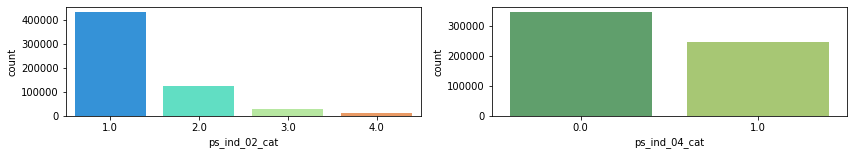

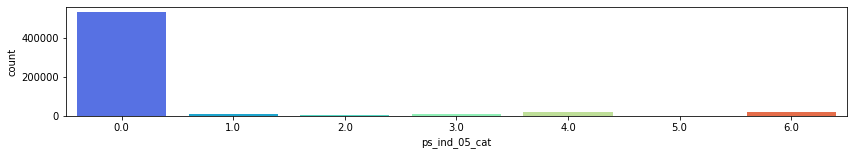

In [17]:
# univariate analysis
fig ,ax = plt.subplots(1,2,figsize=(14,2))
ax1,ax2, = ax.flatten()
sns.countplot(train['ps_ind_02_cat'],palette='rainbow',ax=ax1)
sns.countplot(train['ps_ind_04_cat'],palette='summer',ax=ax2)
fig,ax = plt.subplots(figsize=(14,2))
sns.countplot(train['ps_ind_05_cat'],palette='rainbow',ax=ax)

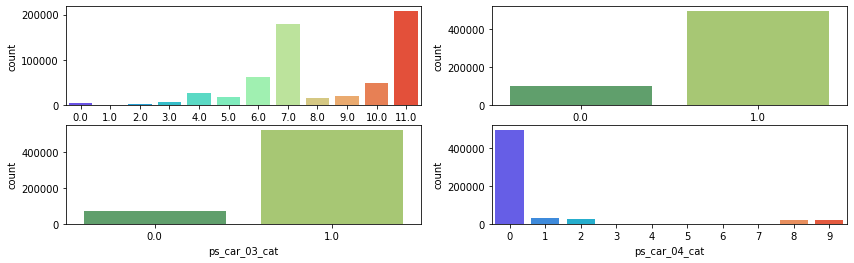

In [18]:
fig,ax = plt.subplots(2,2,figsize=(14,4))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.countplot(train['ps_car_01_cat'],palette='rainbow',ax=ax1)
sns.countplot(train['ps_car_02_cat'],palette='summer',ax=ax2)
sns.countplot(train['ps_car_03_cat'],palette='summer',ax=ax3)
sns.countplot(train['ps_car_04_cat'],palette='rainbow',ax=ax4)